# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [225]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set(style="darkgrid")
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.externals import joblib


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
# Adjust width of notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Data Exploration and Visualisation

## portfolio

In [4]:
portfolio.sort_values(['offer_type', 'duration', 'difficulty'])

,channels,difficulty,duration,id,offer_type,reward
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0


There 10 different offers. I'm surprised that there are two discount-offers (id 5 and 9) where you get more discount if you buy less!

In [5]:
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

## profile

In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [7]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [8]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


became_member_on is int64. We'll have to change it datetime...

Uh, age of 118?? What's that?

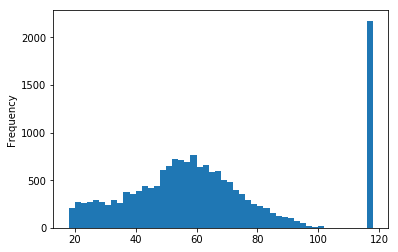

In [9]:
profile['age'].plot.hist(bins=50);

Seems that there are some users whith an age of 118.Do they all are of gender "None" and income "NaN"?

In [10]:
profile[~((profile['age']==118) & (~profile['gender'].isin(['M', 'F'])) & (profile['income'].isna()))].isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

Okay, customers with age==118, gender==None and income==NaN are the only "strange" datapoints here.

So maybe we split the users into these strange group and the group with all data filled correctly. 

### Distribution of Gender and Income

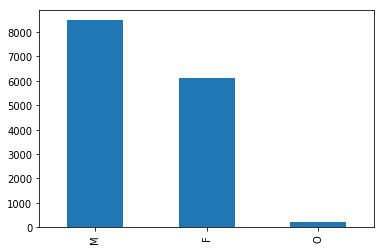

In [11]:
profile['gender'].value_counts().plot(kind='bar');

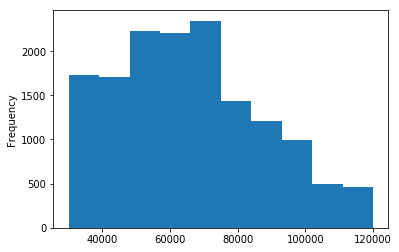

In [12]:
profile['income'].plot.hist();

### Are ids unique?

In [13]:
profile['id'].nunique() == profile['id'].count()

True

Great!

## transcript

In [14]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


### Types and Distribution of "event"

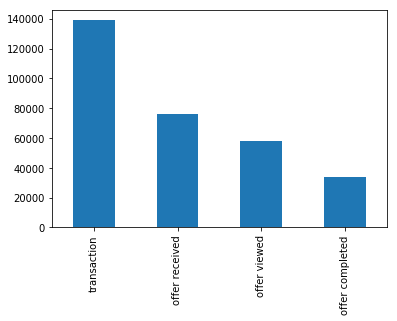

In [15]:
transcript['event'].value_counts().plot(kind='bar');

### Value

This column has to be transformed. It contains different data for different types of event. 
It's a dictionary.
So we need to transform it later on.

### time

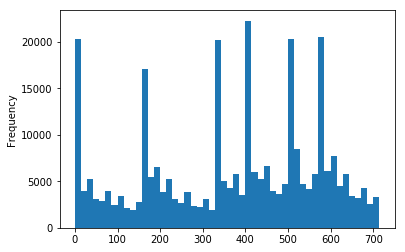

In [16]:
transcript['time'].plot.hist(bins=50);

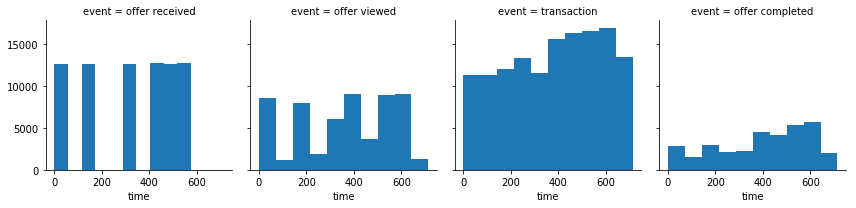

In [17]:
g = sns.FacetGrid(transcript, col="event", margin_titles=True)
g.map(plt.hist, "time");

How's the data for one (random chosen) person?

In [18]:
transcript[transcript['person']=='ec70faa2792f4ee19d67dca4957d285f']

,event,person,time,value
6403,offer received,ec70faa2792f4ee19d67dca4957d285f,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
57248,offer received,ec70faa2792f4ee19d67dca4957d285f,168,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
67008,offer viewed,ec70faa2792f4ee19d67dca4957d285f,168,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
89459,transaction,ec70faa2792f4ee19d67dca4957d285f,228,{'amount': 2.88}
157073,offer received,ec70faa2792f4ee19d67dca4957d285f,408,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
168812,offer viewed,ec70faa2792f4ee19d67dca4957d285f,414,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
172193,transaction,ec70faa2792f4ee19d67dca4957d285f,420,{'amount': 3.49}
187765,transaction,ec70faa2792f4ee19d67dca4957d285f,456,{'amount': 4.68}
207978,offer received,ec70faa2792f4ee19d67dca4957d285f,504,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
231198,offer viewed,ec70faa2792f4ee19d67dca4957d285f,534,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}


Okay, this person gets three different offers: 3f207df678b143eea3cee63160fa8bed, 5a8bc65990b245e5a138643cd4eb9837 and 2298d6c36e964ae4a3e7e9706d1fb8c2.
The third one is offered several times.

So let's check how many offers each person gets.


In [19]:
no_events_by_person = transcript.groupby(['person', 'event'])['time'].count()
no_events_by_person.head(10)

person                            event          
0009655768c64bdeb2e877511632db8f  offer completed    3
                                  offer received     5
                                  offer viewed       4
                                  transaction        8
00116118485d4dfda04fdbaba9a87b5c  offer received     2
                                  offer viewed       2
                                  transaction        3
0011e0d4e6b944f998e987f904e8c1e5  offer completed    3
                                  offer received     5
                                  offer viewed       5
Name: time, dtype: int64

In [20]:
# bring dataFrame to wide format
no_events_by_person_wide = no_events_by_person.unstack(fill_value=0)
no_events_by_person_wide.head(10)

event,offer completed,offer received,offer viewed,transaction
person,,,,
0009655768c64bdeb2e877511632db8f,3,5,4,8
00116118485d4dfda04fdbaba9a87b5c,0,2,2,3
0011e0d4e6b944f998e987f904e8c1e5,3,5,5,5
0020c2b971eb4e9188eac86d93036a77,3,5,3,8
0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,12
003d66b6608740288d6cc97a6903f4f0,3,5,4,18
00426fe3ffde4c6b9cb9ad6d077a13ea,1,5,2,17
004b041fbfe44859945daa2c7f79ee64,2,3,2,6
004c5799adbf42868b9cff0396190900,5,5,4,12


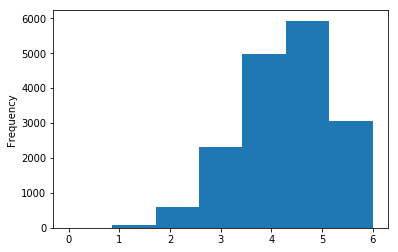

In [21]:
no_events_by_person_wide['offer received'].plot.hist(bins=7);

Most of all people get more than one offer.

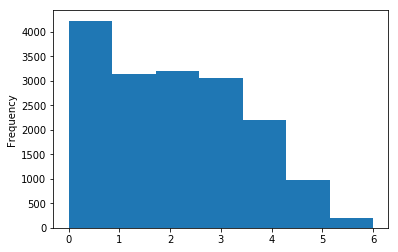

In [22]:
no_events_by_person_wide['offer completed'].plot.hist(bins=7);

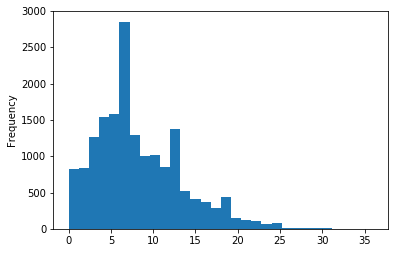

In [23]:
no_events_by_person_wide['transaction'].plot.hist(bins=30);

# Data Preprocessing

## portfolio
Create single columns for each channel.

In [24]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [25]:
def get_all_channels(portfolio):
    """
    get all channels used in all rows of a portfolio of offers.
    
    Parameters:
    -----------
    portfolio: dataframe as given by raw data
    
    Return:
    -------
    List of all used channels
    """
    
    unique_channels = set()
    
    channels = portfolio['channels']
    for row in channels:
        unique_channels = unique_channels.union(set(row))
    
    unique_channels = list(unique_channels)
    unique_channels.sort()
    return(unique_channels)
    
all_channels = get_all_channels(portfolio)
print(all_channels)

['email', 'mobile', 'social', 'web']


In [26]:
def one_hot_encode_channels(portfolio):
    """
    Convert the column channels to single 0/1 columns for each channel
    """
    one_hot = MultiLabelBinarizer()
    new_columns = one_hot.fit_transform(portfolio['channels'])
    new_columns_df = pd.DataFrame(new_columns, columns=one_hot.classes_)
    
    output = pd.concat([portfolio, new_columns_df], axis=1)
    
    output.drop('channels', axis=1, inplace=True)
    return(output)

portfolio_df = one_hot_encode_channels(portfolio)

In [27]:
portfolio_df.sort_values(['offer_type', 'duration', 'difficulty'])

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1


## profile

In [28]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Convert "became_member_on" to date

In [29]:
def convert_column_todate(profile):
    """
    Convert the column "became_member_on" to datetime
    
    Parameter:
    ----------
    profile: dataframe as given by raw data
    
    Return:
    -------
    copy of input with converted column
    """
    
    profile = profile.copy()
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format="%Y%m%d")
    return(profile)

profile_df = convert_column_todate(profile)

In [30]:
profile_df.head(10)

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,2016-11-22,None,8974fc5686fe429db53ddde067b88302,NaN


In [31]:
def split_profile_data(profile):
    """
    Splits the input profile data into two dataframes: 
    one with age==118, gender==None, income==NaN
    the other with the rest
    """
    profile_regular = profile[~((profile['age']==118) & (~profile['gender'].isin(['M', 'F'])) & (profile['income'].isna()))]
    profile_strange = profile[((profile['age']==118) & (~profile['gender'].isin(['M', 'F'])) & (profile['income'].isna()))]
    
    return profile_regular, profile_strange

profile_regular_df, profile_strange_df = split_profile_data(profile_df)

In [32]:
profile_regular_df.head(10)

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0
13,61,2017-09-11,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0
14,26,2014-02-13,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0
15,62,2016-02-11,F,31dda685af34476cad5bc968bdb01c53,71000.0
16,49,2014-11-13,M,62cf5e10845442329191fc246e7bcea3,52000.0
18,57,2017-12-31,M,6445de3b47274c759400cd68131d91b4,42000.0


In [33]:
profile_strange_df.head(10)

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,2016-11-22,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,2017-08-24,None,c4863c7985cf408faee930f111475da3,NaN
11,118,2015-09-19,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,2017-08-01,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,2017-09-07,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


Let's check the distribution of 'became_member_on' in both dataframes:

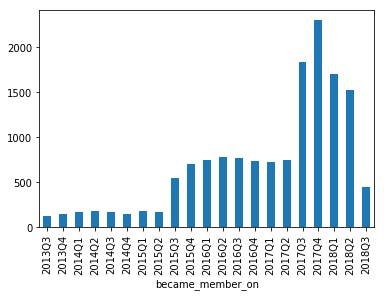

In [34]:
profile_regular_df.groupby(profile_regular_df['became_member_on'].dt.to_period('Q'))['id'].count().plot(kind="bar");

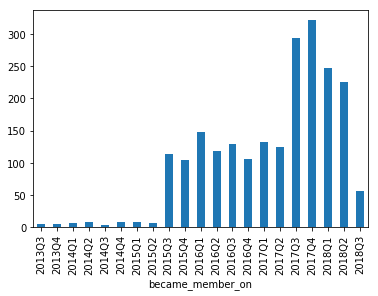

In [35]:
profile_strange_df.groupby(profile_strange_df['became_member_on'].dt.to_period('Q'))['id'].count().plot(kind="bar");

Okay, it seems both dataframes has the same distribution

## transcript

In [36]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


The column value can hold more than one key-value pair: 

In [37]:
transcript.loc[306527, 'value']

{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}

So what are the possible keys?

In [38]:
def extract_value_keys(value):
    '''
    Get the keys of a value-dictionary
    '''
    return np.array(list(value.keys())).astype(object)


d=(transcript['value'].apply(lambda x: extract_value_keys(x)).to_numpy())
set(np.hstack(d))

{'amount', 'offer id', 'offer_id', 'reward'}

Uuhh, 'offer id' and 'offer_id' with underscore,.....
So we need to unify this

In [40]:
def generate_value_columns(value):
    '''
    Split the value-dictionary and return a pandas.Series.
    Unify 'offer id' and 'offer_id'
    
    Paramters:
    ----------
    value: dictionary
    
    Return:
    -------
    Pandas.Series with values for 'amount', 'offer_id' and 'reward'
    '''
    new_columns = pd.Series({'amount': np.nan, 'offer_id': np.nan, 'reward': np.nan})
    
    for item in value.items():
        if item[0] == 'offer id':
            key = 'offer_id'
        else:
            key = item[0]
        new_columns[key] = item[1]    
            
    return new_columns


transcript_df = transcript.copy()
transcript_df[['amount', 'offer_id', 'reward']] = transcript_df['value'].apply(lambda x: generate_value_columns(x))
transcript_df.drop(['value'], axis=1, inplace=True)

### Inspect the events of one person
Now let's take a look at the events a single person has got.

In [41]:
tmp = transcript_df.sort_values(['person', 'time'])
tmp[tmp['person'] == 'ec70faa2792f4ee19d67dca4957d285f']


,event,person,time,amount,offer_id,reward
6403,offer received,ec70faa2792f4ee19d67dca4957d285f,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN
57248,offer received,ec70faa2792f4ee19d67dca4957d285f,168,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
67008,offer viewed,ec70faa2792f4ee19d67dca4957d285f,168,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
89459,transaction,ec70faa2792f4ee19d67dca4957d285f,228,2.88,NaN,NaN
157073,offer received,ec70faa2792f4ee19d67dca4957d285f,408,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
168812,offer viewed,ec70faa2792f4ee19d67dca4957d285f,414,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
172193,transaction,ec70faa2792f4ee19d67dca4957d285f,420,3.49,NaN,NaN
187765,transaction,ec70faa2792f4ee19d67dca4957d285f,456,4.68,NaN,NaN
207978,offer received,ec70faa2792f4ee19d67dca4957d285f,504,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
231198,offer viewed,ec70faa2792f4ee19d67dca4957d285f,534,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN


As we've seen before this person got several times the same offer. So we have to distinguish between these offers and check how long each single offer is valid.

Therefor we merge the transcript_df dataframe with portfolio_df.

In [42]:
tmp = transcript_df.merge(portfolio_df, left_on='offer_id', right_on='id', suffixes=('_tr', '_pf')).drop(['id'], axis=1)

Let's look at the "offer received" events:

In [43]:
tmp[(tmp['person'] == 'ec70faa2792f4ee19d67dca4957d285f') & (tmp['event'] == 'offer received')].sort_values('time')

,event,person,time,amount,offer_id,reward_tr,difficulty,duration,offer_type,reward_pf,email,mobile,social,web
124094,offer received,ec70faa2792f4ee19d67dca4957d285f,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0,4,informational,0,1,1,0,1
106889,offer received,ec70faa2792f4ee19d67dca4957d285f,168,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1
161074,offer received,ec70faa2792f4ee19d67dca4957d285f,408,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,3,informational,0,1,1,1,0
117031,offer received,ec70faa2792f4ee19d67dca4957d285f,504,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1
120611,offer received,ec70faa2792f4ee19d67dca4957d285f,576,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1


In [44]:
tmp['offer_rank'] = tmp[tmp['event'] == 'offer received'].groupby(['person'])['time'].rank(method="first", ascending=True)


In [45]:
tmp[(tmp['person'] == 'ec70faa2792f4ee19d67dca4957d285f')].sort_values('time')


,event,person,time,amount,offer_id,reward_tr,difficulty,duration,offer_type,reward_pf,email,mobile,social,web,offer_rank
124094,offer received,ec70faa2792f4ee19d67dca4957d285f,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0,4,informational,0,1,1,0,1,1.0
106889,offer received,ec70faa2792f4ee19d67dca4957d285f,168,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1,2.0
107862,offer viewed,ec70faa2792f4ee19d67dca4957d285f,168,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1,NaN
161074,offer received,ec70faa2792f4ee19d67dca4957d285f,408,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,3,informational,0,1,1,1,0,3.0
162014,offer viewed,ec70faa2792f4ee19d67dca4957d285f,414,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,3,informational,0,1,1,1,0,NaN
117031,offer received,ec70faa2792f4ee19d67dca4957d285f,504,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1,4.0
118987,offer viewed,ec70faa2792f4ee19d67dca4957d285f,534,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1,NaN
120611,offer received,ec70faa2792f4ee19d67dca4957d285f,576,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1,5.0
121079,offer viewed,ec70faa2792f4ee19d67dca4957d285f,576,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1,NaN
123436,offer completed,ec70faa2792f4ee19d67dca4957d285f,714,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,7,7,discount,3,1,1,1,1,NaN


Now each 'offer received' event for one person has a unique number. 

Now we put the offer_rank of each 'offer received' to the following "offer"-events with fill-forward:

In [46]:
tmp[['offer_rank']] = tmp.groupby(['person', 'offer_id'])[['offer_rank']].fillna(method='ffill')

In [47]:
tmp[(tmp['person'].isin(['ec70faa2792f4ee19d67dca4957d285f']))].sort_values(['person','time'])

,event,person,time,amount,offer_id,reward_tr,difficulty,duration,offer_type,reward_pf,email,mobile,social,web,offer_rank
124094,offer received,ec70faa2792f4ee19d67dca4957d285f,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0,4,informational,0,1,1,0,1,1.0
106889,offer received,ec70faa2792f4ee19d67dca4957d285f,168,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1,2.0
107862,offer viewed,ec70faa2792f4ee19d67dca4957d285f,168,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1,2.0
161074,offer received,ec70faa2792f4ee19d67dca4957d285f,408,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,3,informational,0,1,1,1,0,3.0
162014,offer viewed,ec70faa2792f4ee19d67dca4957d285f,414,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,3,informational,0,1,1,1,0,3.0
117031,offer received,ec70faa2792f4ee19d67dca4957d285f,504,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1,4.0
118987,offer viewed,ec70faa2792f4ee19d67dca4957d285f,534,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1,4.0
120611,offer received,ec70faa2792f4ee19d67dca4957d285f,576,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1,5.0
121079,offer viewed,ec70faa2792f4ee19d67dca4957d285f,576,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,7,7,discount,3,1,1,1,1,5.0
123436,offer completed,ec70faa2792f4ee19d67dca4957d285f,714,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,7,7,discount,3,1,1,1,1,5.0


Now it's important that the events occur in the correct order: offer received, offer viewed and offer completed.

As we can see below that's not always the case: Person 78afa995795e4d85b5d9ceeca43f5fef completes offer f19421c1d4aa40978ebb69ca19b0e20d before she viewed it.


In [48]:
tmp[(tmp['person'].isin(['ec70faa2792f4ee19d67dca4957d285f', '78afa995795e4d85b5d9ceeca43f5fef']))].sort_values(['person','time'])

,event,person,time,amount,offer_id,reward_tr,difficulty,duration,offer_type,reward_pf,email,mobile,social,web,offer_rank
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,7,bogo,5,1,1,0,1,1.0
1393,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,7,bogo,5,1,1,0,1,1.0
2427,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5,7,bogo,5,1,1,0,1,1.0
155716,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,3,informational,0,1,1,1,0,2.0
157886,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,3,informational,0,1,1,1,0,2.0
144044,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10,7,bogo,10,1,1,1,0,3.0
145322,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,408,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10,7,bogo,10,1,1,1,0,3.0
96750,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5,5,bogo,5,1,1,1,1,4.0
98462,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5,5,bogo,5,1,1,1,1,4.0
148698,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10,7,bogo,10,1,1,1,0,3.0


To check for the order we create a new column containing all appeared events for each person, offer, offer_rank:

In [49]:
tmp['offer_actions'] = tmp.sort_values('time').groupby(['person', 'offer_id', 'offer_rank'], group_keys=False)['event'].transform(lambda x: x.str.cat(sep=", "))
tmp[(tmp['person'].isin(['ec70faa2792f4ee19d67dca4957d285f', '78afa995795e4d85b5d9ceeca43f5fef']))].sort_values(['person','time'])

,event,person,time,amount,offer_id,reward_tr,difficulty,duration,offer_type,reward_pf,email,mobile,social,web,offer_rank,offer_actions
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,7,bogo,5,1,1,0,1,1.0,"offer received, offer viewed, offer completed"
1393,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,7,bogo,5,1,1,0,1,1.0,"offer received, offer viewed, offer completed"
2427,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5,7,bogo,5,1,1,0,1,1.0,"offer received, offer viewed, offer completed"
155716,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,3,informational,0,1,1,1,0,2.0,"offer received, offer viewed"
157886,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,3,informational,0,1,1,1,0,2.0,"offer received, offer viewed"
144044,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10,7,bogo,10,1,1,1,0,3.0,"offer received, offer viewed, offer completed"
145322,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,408,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10,7,bogo,10,1,1,1,0,3.0,"offer received, offer viewed, offer completed"
96750,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5,5,bogo,5,1,1,1,1,4.0,"offer received, offer completed, offer viewed"
98462,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5,5,bogo,5,1,1,1,1,4.0,"offer received, offer completed, offer viewed"
148698,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10,7,bogo,10,1,1,1,0,3.0,"offer received, offer viewed, offer completed"


Now we can filter for all lines with the correct sequence of offer_actions. offer_actions has to be "offer received, offer viewed, offer completed".
Also just pick the rows with the completion.

In [50]:
completed_offers = tmp[(tmp['offer_actions'] == "offer received, offer viewed, offer completed") & (tmp['event'] == "offer completed")]
completed_offers.head()

,event,person,time,amount,offer_id,reward_tr,difficulty,duration,offer_type,reward_pf,email,mobile,social,web,offer_rank,offer_actions
1248,offer completed,629fc02d56414d91bca360decdfa9288,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5,7,bogo,5,1,1,0,1,1.0,"offer received, offer viewed, offer completed"
1270,offer completed,60b8a75638d2461b988ba4f089f8ad24,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5,7,bogo,5,1,1,0,1,1.0,"offer received, offer viewed, offer completed"
1308,offer completed,83d2641895054948946aa6e898b85632,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5,7,bogo,5,1,1,0,1,1.0,"offer received, offer viewed, offer completed"
1334,offer completed,c0231649f05d40889e3a6e1172303b37,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5,7,bogo,5,1,1,0,1,1.0,"offer received, offer viewed, offer completed"
1336,offer completed,329a9b32e7e0475cb2643125919c4d90,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5,7,bogo,5,1,1,0,1,1.0,"offer received, offer viewed, offer completed"


So now we've got a dataframe with all "really" completed offers: Only those which very first received, then viewed and then completed. As we can see above this may happen at the same time.

E.g. the first person above:

In [51]:
transcript_df.query("person == '629fc02d56414d91bca360decdfa9288' & offer_id == '9b98b8c7a33c4b65b9aebfe6a799e6d9'")

,event,person,time,amount,offer_id,reward
125,offer received,629fc02d56414d91bca360decdfa9288,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
12677,offer viewed,629fc02d56414d91bca360decdfa9288,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0


The reason is that the transaction happened also at time == 0:

In [52]:
transcript_df.query("person == '629fc02d56414d91bca360decdfa9288' & time == 0")

,event,person,time,amount,offer_id,reward
125,offer received,629fc02d56414d91bca360decdfa9288,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
12677,offer viewed,629fc02d56414d91bca360decdfa9288,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
12678,transaction,629fc02d56414d91bca360decdfa9288,0,33.9,NaN,NaN
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0


So let's get the count of converted offers person and offer_id:

In [71]:
completed_offers_per_person_and_id = completed_offers.groupby(['person', 'offer_id'])['event'].agg('count')
completed_offers_per_person_and_id.head()

person                            offer_id                        
0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7    1
                                  2298d6c36e964ae4a3e7e9706d1fb8c2    1
                                  9b98b8c7a33c4b65b9aebfe6a799e6d9    1
0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0    1
                                  fafdcd668e3743c1bb461111dcafc2a4    1
Name: event, dtype: int64

Also get the same for "offer received":


In [73]:
received_offers_per_person_and_id = transcript_df[transcript_df['event'] == "offer received"].groupby(['person', 'offer_id'])['event'].agg('count')
received_offers_per_person_and_id.head()

person                            offer_id                        
0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5    1
                                  3f207df678b143eea3cee63160fa8bed    1
                                  5a8bc65990b245e5a138643cd4eb9837    1
                                  f19421c1d4aa40978ebb69ca19b0e20d    1
                                  fafdcd668e3743c1bb461111dcafc2a4    1
Name: event, dtype: int64

So now we can create a dataframe with successrate for each person and each offer_id. The success_rate will be the variable we'll predict later on:

In [81]:
offers_per_person = pd.concat([received_offers_per_person_and_id.rename('received'), completed_offers_per_person_and_id.rename('completed')], axis=1).fillna(value=0).reset_index()
offers_per_person['success_rate'] = offers_per_person['completed'] / offers_per_person['received'] * 100
offers_per_person.head()

,person,offer_id,received,completed,success_rate
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,0.0,0.0


Now we can merge this dataframe with the dataframe containing all attributes of the persons.

As we've seen above there are two kind of dataframes: profile_regular_df and profile_strange_df

In [97]:
data_regular = pd.merge(offers_per_person, profile_regular_df, left_on='person', right_on='id').drop(columns=['id', 'received', 'completed'], axis=1).set_index('person')
# put success_rate (the dependant variable) at the end of the dataframe
data_regular['success_rate'] = data_regular.pop('success_rate')

data_strange = pd.merge(offers_per_person, profile_strange_df, left_on='person', right_on='id').drop(columns=['id', 'received', 'completed', 'age', 'gender', 'income'], axis=1).set_index('person')
# put success_rate (the dependant variable) at the end of the dataframe
data_strange['success_rate'] = data_strange.pop('success_rate')

data_regular.head()

,offer_id,age,became_member_on,gender,income,success_rate
person,,,,,,
0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,33,2017-04-21,M,72000.0,0.0
0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,33,2017-04-21,M,72000.0,0.0
0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,33,2017-04-21,M,72000.0,0.0
0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,33,2017-04-21,M,72000.0,0.0
0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,33,2017-04-21,M,72000.0,0.0


In [98]:
data_strange.head()

,offer_id,became_member_on,success_rate
person,,,
00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,2018-04-25,0.0
0063def0f9c14bc4805322a488839b32,0b1e1539f2cc45b7b9fa7c272da2e1d7,2018-06-15,0.0
0063def0f9c14bc4805322a488839b32,2298d6c36e964ae4a3e7e9706d1fb8c2,2018-06-15,0.0
0063def0f9c14bc4805322a488839b32,5a8bc65990b245e5a138643cd4eb9837,2018-06-15,0.0
0063def0f9c14bc4805322a488839b32,9b98b8c7a33c4b65b9aebfe6a799e6d9,2018-06-15,0.0


# Build the model

Let's build a ML-pipeline to test several models

First we want to classify our users. So let's switch from success_rate to success yes or no:

In [213]:
data_regular['success_rate'] = data_regular['success_rate'].apply(lambda x: 1 if x >0 else 0)

In [214]:
X = data_regular.iloc[ : , 0:-1]
y = data_regular.iloc[ : , -1]

# X['became_member_on'] = pd.to_datetime(X['became_member_on'])
X['became_member_on'] = pd.to_datetime(X['became_member_on']).astype(int).astype(float)
X['age'] = X['age'].astype(int).astype(float)


X_train, X_test, y_train, y_test = train_test_split(X, y)

In [215]:
X.dtypes

offer_id             object
age                 float64
became_member_on    float64
gender               object
income              float64
dtype: object

In [217]:
X_test.head()

,offer_id,age,became_member_on,gender,income
person,,,,,
9c64321646bf40f6ad1bc98864eaa6b8,4d5c57ea9a6940dd891ad53e9dbe8da0,48.0,1.476403e+18,F,53000.0
6ce10f73aa954c7e8211f4fbce7606b6,4d5c57ea9a6940dd891ad53e9dbe8da0,63.0,1.524096e+18,M,50000.0
840cc4f0ccbb4ba7af0c511ec023ee85,2906b810c7d4411798c6938adc9daaa5,55.0,1.480464e+18,M,41000.0
086948f6255845fca809c982f452e311,fafdcd668e3743c1bb461111dcafc2a4,42.0,1.524442e+18,M,54000.0
8b7cb825575046b49bac1174259f446b,2906b810c7d4411798c6938adc9daaa5,49.0,1.501459e+18,M,48000.0


In [218]:
preprocess_transformer = make_column_transformer(
    (StandardScaler(), ['age', 'became_member_on', 'income']),
    (OneHotEncoder(), ['offer_id', 'gender']),
    )

In [221]:
pipeline = Pipeline([
    ('preprocess', preprocess_transformer),
    ('clf', RandomForestClassifier(n_estimators=100)),
])

In [222]:
# train classifier
pipeline.fit(X_train, y_train)
 
# evaluate all steps on test set
predicted = pipeline.predict(X_test)

In [224]:
accuracy_score(y_test, predicted)

0.71802115022454

In [226]:
confusion_matrix(y_test, predicted)

array([[8362, 1523],
       [2370, 1551]])

In [228]:
pipeline.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
            transformer_weights=None,
            transformers=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True), ['age', 'became_member_on', 'income']), ('onehotencoder', OneHotEncoder(categorical_features=None, categories=None,
          dtype=<class 'numpy.float64'>, handle_unknown='error',
          n_values=None, sparse=True), ['offer_id', 'gender'])])),
  ('clf',
   RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False))],
 'preprocess': ColumnTransformer(n_

In [236]:
parameters = { 
    'clf__max_depth': [5, 10, 20, 50, 100],
    'clf__n_estimators': [20, 50, 100, 500, 1000]
}

cv = GridSearchCV(pipeline, param_grid=parameters, verbose=10, cv=3, n_jobs=12)

cv.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    7.7s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   20.9s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:   32.6s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:   53.2s
[Parallel(n_jobs=12)]: Done  60 out of  75 | elapsed:  1.3min remaining:   20.0s
[Parallel(n_jobs=12)]: Done  68 out of  75 | elapsed:  2.0min remaining:   12.3s
[Parallel(n_jobs=12)]: Done  75 out of  75 | elapsed:  2.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True), ['age', 'became_member_on', 'income']), ('onehotencoder', OneHotEncoder(...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=12,
       param_grid={'clf__max_depth': [5, 10, 20, 50, 100], 'clf__n_estimators': [20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [237]:
y_pred = cv.predict(X_test)
print(cv.best_params_)
print(cv.best_score_)
print(accuracy_score(y_test, y_pred)) 

{'clf__max_depth': 10, 'clf__n_estimators': 500}
0.7415733050028974
0.7425756917282341
